# Image processing

## INT3404 20 ----- 8-10 Monday - 309GD3
## Diep Ng., Ph.D.

### Mail-to: ngocdiep at vnu.edu.vn



In [1]:
!python --version

Python 3.6.8 :: Anaconda, Inc.


# Week 3: Histogram

In [2]:
%matplotlib inline


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils

In [4]:
plt.rcParams['figure.figsize'] = [12,10]

## 1. Calculate Histogram

### 1.1. Using `cv2.calcHist` from OpenCV

```
#using cv2.calcHist()
hist = cv2.calcHist(
                    [img],
                    channels=[0],
                    mask=None, #full image
                    histSize=[256], #full scale
                    ranges=[0,256]
)

```

### 1.2. Using `numpy.histogram` function

```
#using numpy 
h2 = np.histogram(img.ravel(), bins=256, range=[0, 256])
```



In [24]:
def read_and_display(iname):
    
    if type(iname) == str:
        #read image
        img1 = cv2.imread(iname)
    else:
        img1 = iname
        
    if len(img1.shape) == 3:
        #convert to gray
        gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    else:
        gray1 = iname
    
    #size of image
    h1, w1 = img1.shape[:2]

    #calculate histogram
    hist1 = cv2.calcHist(
                        [gray1],
                        channels=[0],
                        mask=None, #full image
                        histSize=[256], #full scale
                        ranges=[0,256]
    )

    # normalized histogram
    norm_hist1 = hist1/(h1*w1)
    #cumulative histogram
    cdf1 = norm_hist1.cumsum()
    
    #plot image
    
    plt.subplot(2,2,1)
    plt.imshow(img1[:,:,::-1])
    plt.title("color image")
    plt.subplot(2, 2, 2)
    plt.stem(range(256), hist1, use_line_collection=True)
    plt.title("histogram")
    plt.subplot(2, 2, 3)
    plt.imshow(gray1, cmap='gray')
    plt.title("grayscale image")
    plt.subplot(2, 2, 4)
    plt.step(range(256), cdf1, c='g')
    plt.title("cumulative histogram")
    plt.show()


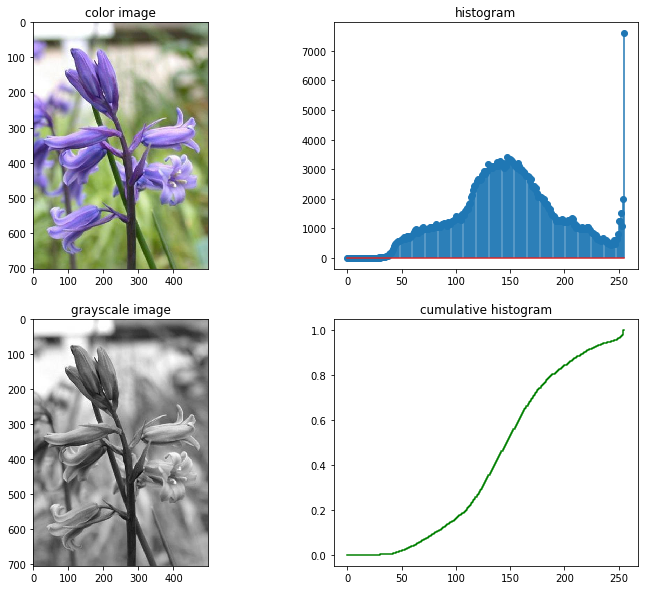

In [25]:
read_and_display("flowers/3.jpg")

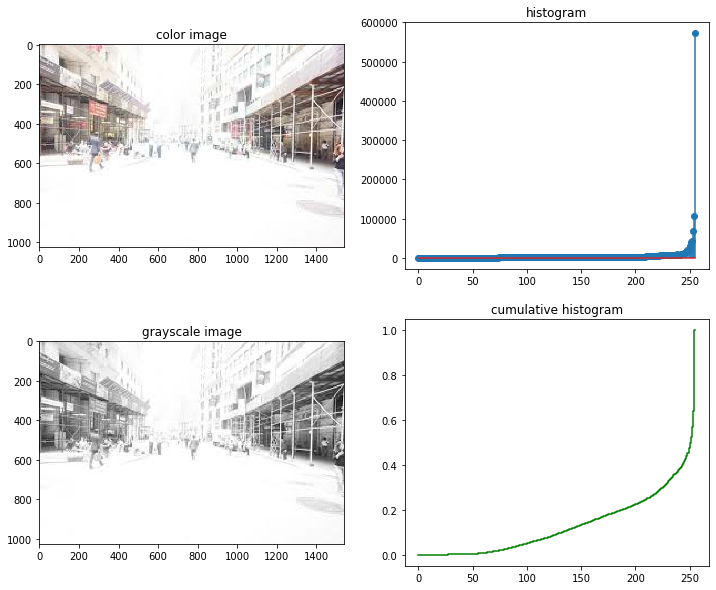

In [26]:
read_and_display("high-exposure.jpg")

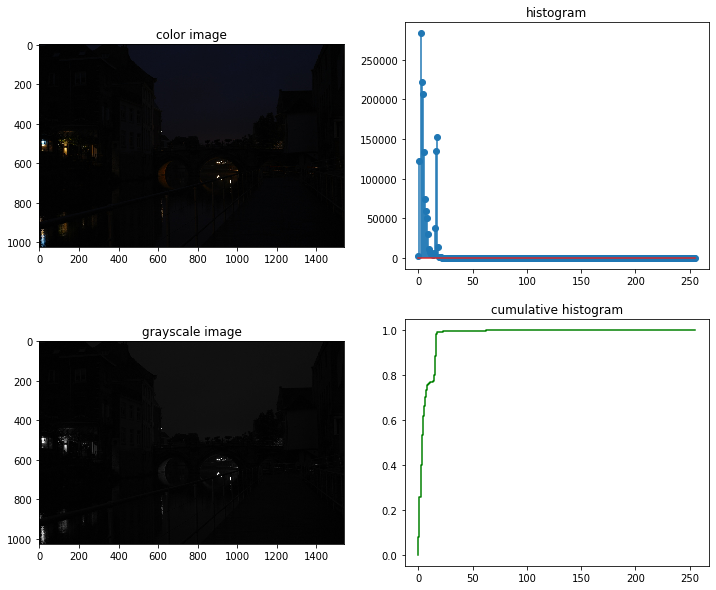

In [27]:
read_and_display("low-exposure.jpg")

## 2. Histogram of enhanced image

### 2.1. Gamma correction

In [40]:
#from week 2
#reference: https://www.pyimagesearch.com/2015/10/05/opencv-gamma-correction/
def adjust_image_gamma_lookuptable(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    table = np.array([((i / 255.0) ** gamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")

    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)


def visualize_before_after(before, after):
    #calculate histogram
    hist = cv2.calcHist(
                        [before],
                        channels=[0],
                        mask=None, #full image
                        histSize=[256], #full scale
                        ranges=[0,256]
    )

    new_hist = cv2.calcHist(
                        [after],
                        channels=[0],
                        mask=None, #full image
                        histSize=[256], #full scale
                        ranges=[0,256]
    )


    #plot image

    plt.subplot(2,2,1)
    plt.imshow(before, cmap='gray')
    plt.title("original image")
    plt.subplot(2, 2, 2)
    plt.stem(range(256), hist, use_line_collection=True)
    plt.title("original histogram")
    plt.subplot(2, 2, 3)
    plt.imshow(after, cmap='gray')
    plt.title("image after")
    plt.subplot(2, 2, 4)
    plt.stem(range(256), new_hist, use_line_collection=True)
    plt.title("histogram after")
    plt.show()

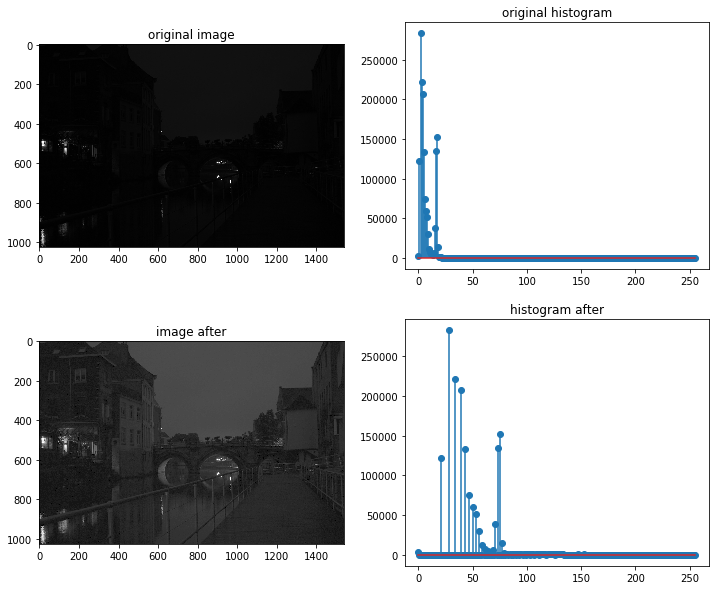

In [41]:
img = cv2.imread("low-exposure.jpg", 0)
img_adjusted = adjust_image_gamma_lookuptable(img, gamma=0.45)

visualize_before_after(img, img_adjusted)


## 3. Histogram equalization


### 3.1. Using user-defined function


In [42]:
def hist_equalize(img):
    s_k = compute_sk(img)
    equalized_img = cv2.LUT(img, s_k)
    return equalized_img


def compute_sk(img):
    #1. calculate hist
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    #2. normalize hist
    h, w = img.shape[:2]
    hist = hist/(h*w)
    
    #3. calculate CDF
    cdf = np.cumsum(hist)
    s_k = (255 * cdf-0.5).astype("uint8")
    return s_k

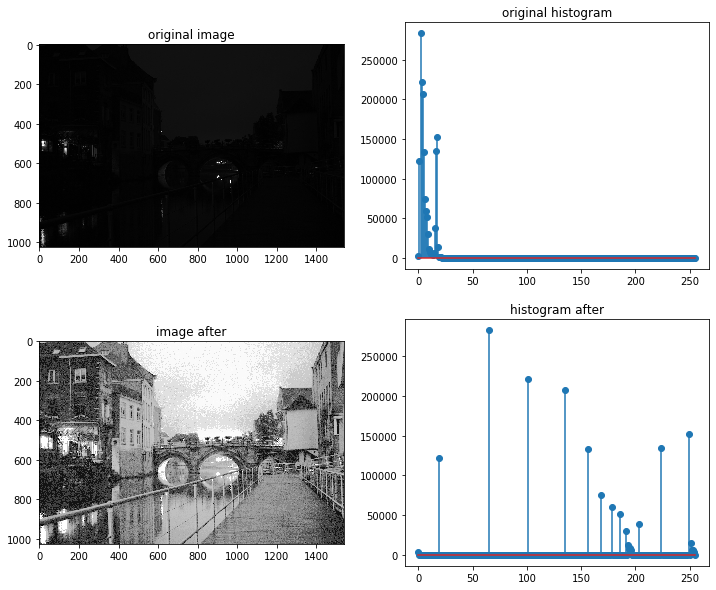

In [43]:
img = cv2.imread("low-exposure.jpg", 0)
equalized_img = hist_equalize(img)

visualize_before_after(img, equalized_img)


### 3.2. Using OpenCV function:  `cv2.equalizeHist(img)`

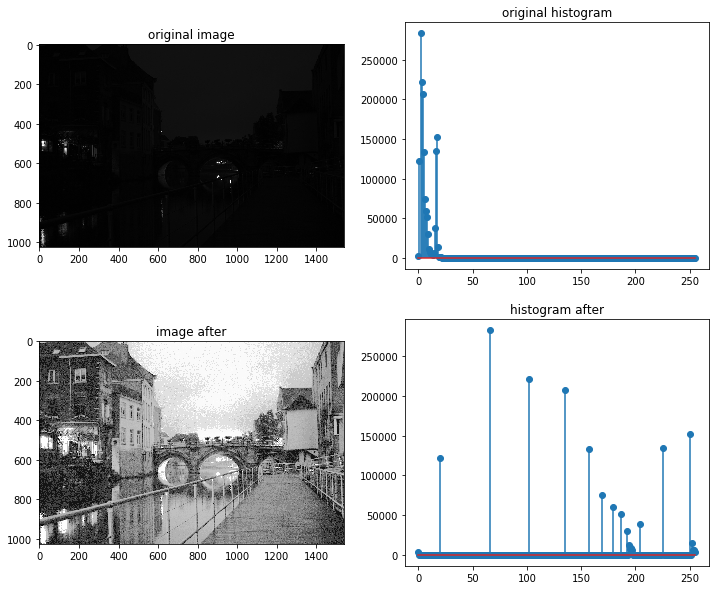

In [44]:
equalized_img_cv2 = cv2.equalizeHist(img)
visualize_before_after(img, equalized_img_cv2)

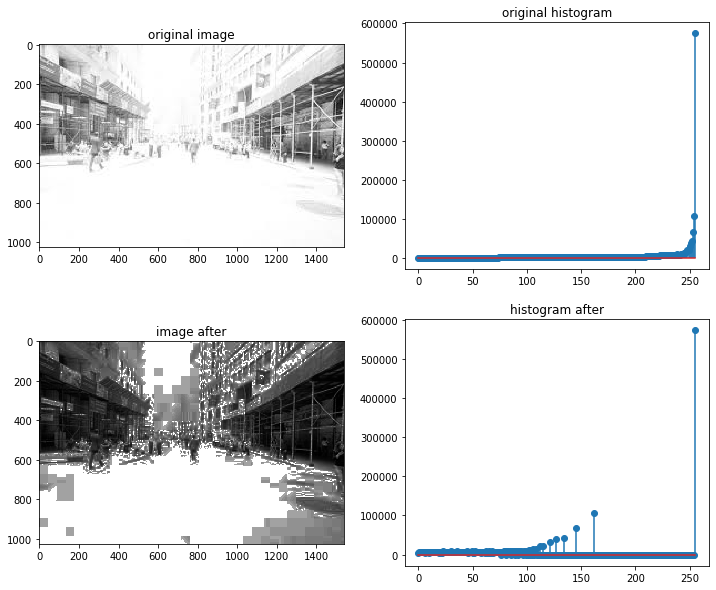

In [45]:
high_exposure_img = cv2.imread('high-exposure.jpg',0)
equalized_high = cv2.equalizeHist(high_exposure_img)

visualize_before_after(high_exposure_img, equalized_high)

# 4. Adaptive Histogram equalization

Image is divided into small blocks called "tiles" (e.g., 8x8 pixels).

Each block is histogram equalized as usual.

In a small area, histogram would confine to a small region (unless there is noise).

If noise is there, it will be amplified --> to avoid this, **contrast limiting* is applied.

If any histogram bin is above the specified contrast limit (e.g., 40), those pixels are clipped and distributed uniformly to other bins before applying histogram equalization. After equalization, to remove artifacts in tile borders, bilinear interpolation is applied.

Refs: https://docs.opencv.org/master/d2/d74/tutorial_js_histogram_equalization.html


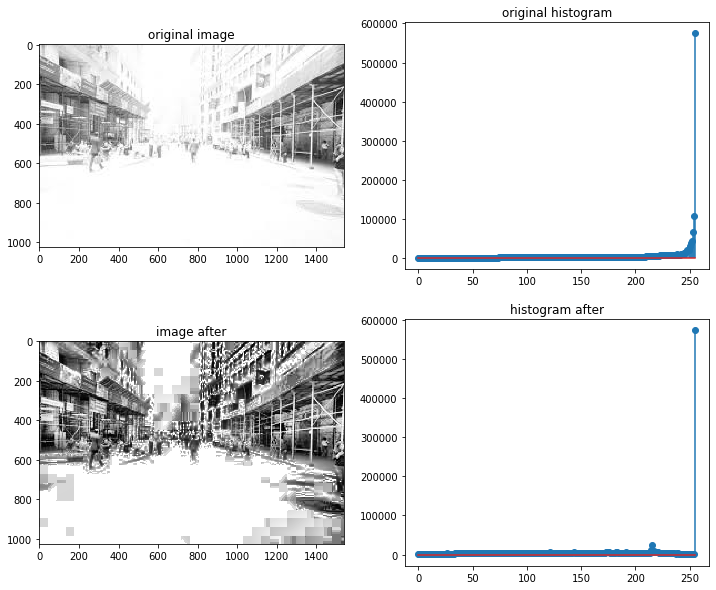

In [46]:
clahe = cv2.createCLAHE(clipLimit=40, tileGridSize=(8,8))
clahe_high = clahe.apply(high_exposure_img)

visualize_before_after(high_exposure_img, clahe_high)

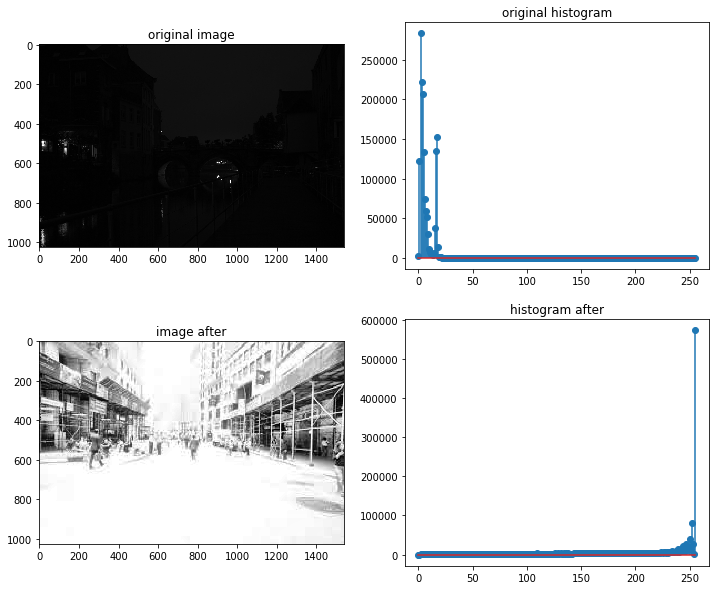

In [47]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clahe_small_clip = clahe.apply(high_exposure_img)

visualize_before_after(img, clahe_small_clip)

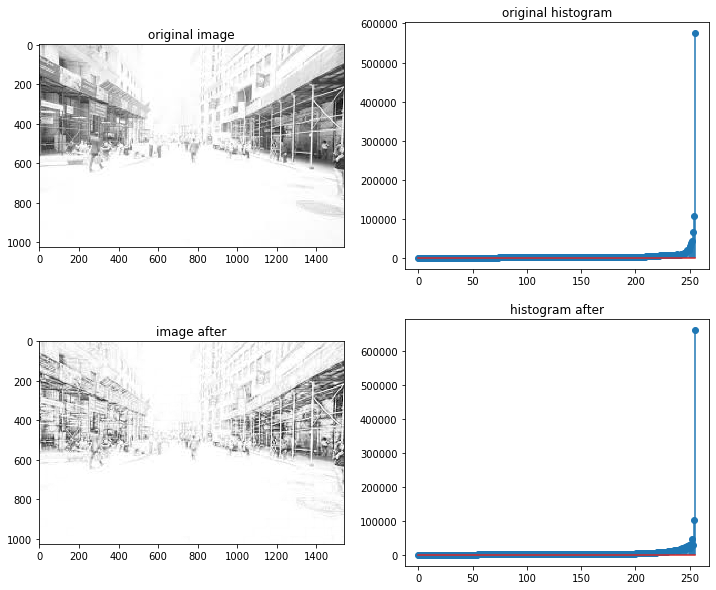

In [48]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(100,100))
clahe_large_grid = clahe.apply(high_exposure_img)

visualize_before_after(high_exposure_img, clahe_large_grid)

# 5. Histogram matching

Compute the cumulative histograms for source & target images
Interpolate linearly to find the unique pixel values in the template image that most closely match the quantiles of the unique pixel values in the source image.

Ref: https://stackoverflow.com/questions/32655686/histogram-matching-of-two-images-in-python-2-x

In [50]:
def hist_match(source, template):
    """
    Adjust the pixel values of a grayscale image such that its histogram
    matches that of a target image

    Arguments:
    -----------
        source: np.ndarray
            Image to transform; the histogram is computed over the flattened
            array
        template: np.ndarray
            Template image; can have different dimensions to source
    Returns:
    -----------
        matched: np.ndarray
            The transformed output image
    """

    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()

    # get the set of unique pixel values and their corresponding indices and
    # counts
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)
    result = interp_t_values[bin_idx].reshape(oldshape)
    result = result.astype(np.uint8)
    return result

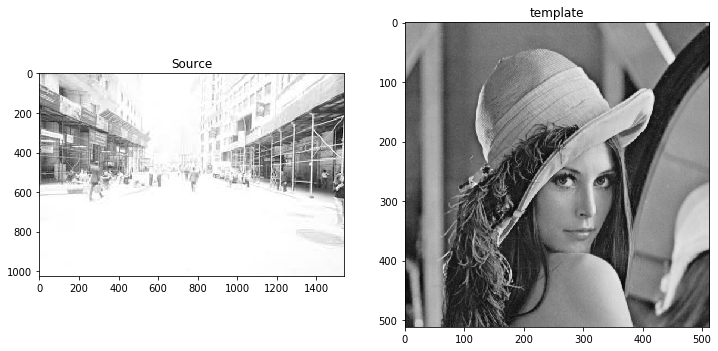

In [51]:
source = cv2.imread("high-exposure.jpg", 0)
template = cv2.imread("lena.jpg",0)
plt.subplot(1, 2, 1)
plt.imshow(source, cmap='gray')
plt.title("Source")
plt.subplot(1,2,2)
plt.imshow(template, cmap='gray')
plt.title("template")
plt.show()

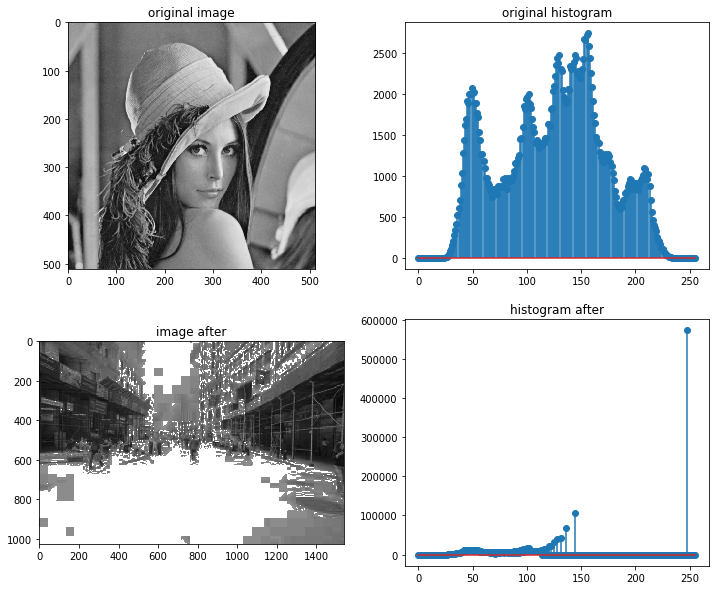

In [52]:
he_matched = hist_match(source, template)

visualize_before_after(template, he_matched)

# 6. Image retrieval using histogram

Flower data from: http://www.robots.ox.ac.uk/~vgg/data/flowers/17/index.html

In [53]:
def calcHist(img, bins_per_channel=20):
    '''
    img with shape (h, w, 3)
    '''
    h, w = img.shape[:2]
    hist = [
            np.histogram(img[:,:, i], bins=20, range=(0, 256))[0]
            for i in range(3)
    ]
    hist = np.array(hist).ravel()
    hist = hist/(h*w) #normalize
    return hist

In [54]:
#all images
import glob
inames = glob.glob("./flowers/*.jpg")
images = [
            cv2.imread(iname)
            for iname in inames
]
#all histograms
xs = [ 
            calcHist(img)
            for img in images
]


In [55]:
#input image
from scipy.spatial import distance
input_img = images[0]
input_hist = xs[0]
all_dists = [
                distance.euclidean(input_hist, xi)
                for xi in xs
]

sorted_idxs = np.argsort(all_dists)

ranked_images = [images[i] for i in sorted_idxs]

In [56]:
sorted_idxs

array([ 0, 10,  3,  8,  5, 11,  6,  2,  9,  7,  1,  4])

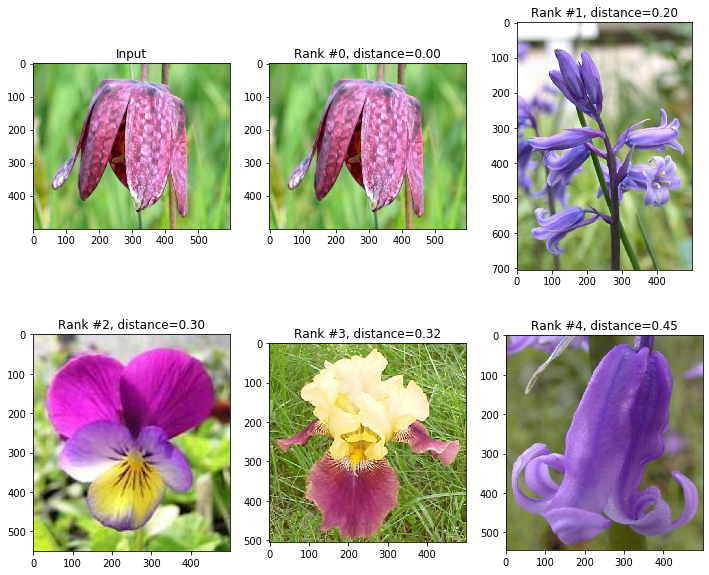

In [57]:
#plot top 5 images
plt.subplot(2, 3, 1)
plt.imshow(input_img[:,:,::-1])
plt.title("Input")
for i in range(0, 5):
    plt.subplot(2, 3, i+2)
    idx = sorted_idxs[i]
    found = ranked_images[i]
    dist = all_dists[idx]
    plt.imshow(found[:,:,::-1])
    plt.title("Rank #{}, distance={:.2f}".format(i, dist))
plt.show()